In [6]:
# Standard library import for python.

import numpy as np 
import pandas as pd 

import os

import seaborn as sns

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

from sklearn.cluster import FeatureAgglomeration
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [13]:
# Load in the train and test datasets from the CSV files.
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
test['Survived'] = pd.NA
data = pd.concat([train, test])
train.shape

(891, 12)

In [ ]:
# sex_label = LabelEncoder()
# cabin_label = LabelEncoder()
# embarked_label = LabelEncoder()
# family_name_label = LabelEncoder()
# title_label = LabelEncoder()
# title_remap_label = LabelEncoder()

# data['Sex_Code'] = sex_label.fit_transform(data.Sex)
# data['Cabin_Prefix'] = data.Cabin.str.get(0).fillna('Z')
# data['Cabin_Code'] = cabin_label.fit_transform(data.Cabin.str.get(0).fillna('Z'))
# data['Has_Cabin'] = (data.Cabin.str.get(0).fillna('Z') != 'Z').astype('int32')
# data['Embarked_fillZ'] = data.Embarked.fillna('Z')
# data['Embarked_Code'] = embarked_label.fit_transform(data.Embarked.fillna('S')) # 'S' has highest occurrence. 
# data['FamilySize'] = data.Parch + data.SibSp + 1
# data['BigFamily'] = data.FamilySize.apply(lambda s: s if s < 5 else 5)
# data['IsAlone'] = data.FamilySize == 1
# data['FamilyName'] = data.Name.str.extract('(\w+),', expand=False)
# data['FamilyName_Code'] = family_name_label.fit_transform(data.FamilyName)
# data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)
# mapping = {
#     'Mlle': 'Miss',
#     'Ms': 'Miss', 
#     'Dona': 'Mrs',
#     'Mme': 'Miss',
#     'Lady': 'Mrs', 
#     'Capt': 'Honorable', 
#     'Countess': 'Honorable', 
#     'Major': 'Honorable', 
#     'Col': 'Honorable', 
#     'Sir': 'Honorable', 
#     'Don': 'Honorable',
#     'Jonkheer': 'Honorable', 
#     'Rev': 'Honorable',
#     'Dr': 'Honorable'
# }
# data['Title_Remap'] = data.Title.replace(mapping)
# data['Title_Code'] = title_label.fit_transform(data.Title)
# data['Title_Remap_Code'] = title_remap_label.fit_transform(data.Title_Remap)
# data.Age = data.Age.fillna(data.Age.median())
# data.Fare = data.Fare.fillna(data.Fare.median())

<>:17: SyntaxWarning: invalid escape sequence '\w'
<>:19: SyntaxWarning: invalid escape sequence '\.'
<>:17: SyntaxWarning: invalid escape sequence '\w'
<>:19: SyntaxWarning: invalid escape sequence '\.'
C:\Users\薛淞之\AppData\Local\Temp\ipykernel_18520\656065175.py:17: SyntaxWarning: invalid escape sequence '\w'
  data['FamilyName'] = data.Name.str.extract('(\w+),', expand=False)
C:\Users\薛淞之\AppData\Local\Temp\ipykernel_18520\656065175.py:19: SyntaxWarning: invalid escape sequence '\.'
  data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)


In [14]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

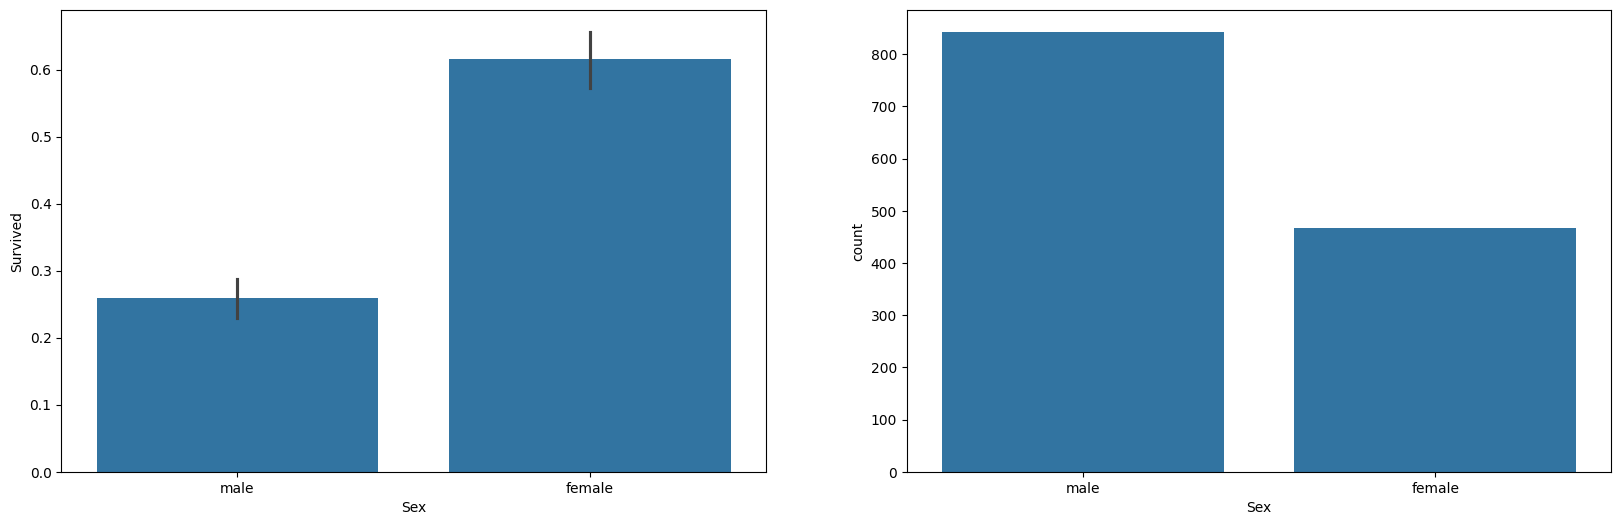

In [18]:
def inspect_feature_plot(data, feat):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))
    sns.barplot(data=data, x=feat, y='Survived', ax=ax1)
    sns.countplot(data=data, x=feat,ax=ax2)

inspect_feature_plot(data, 'Sex')

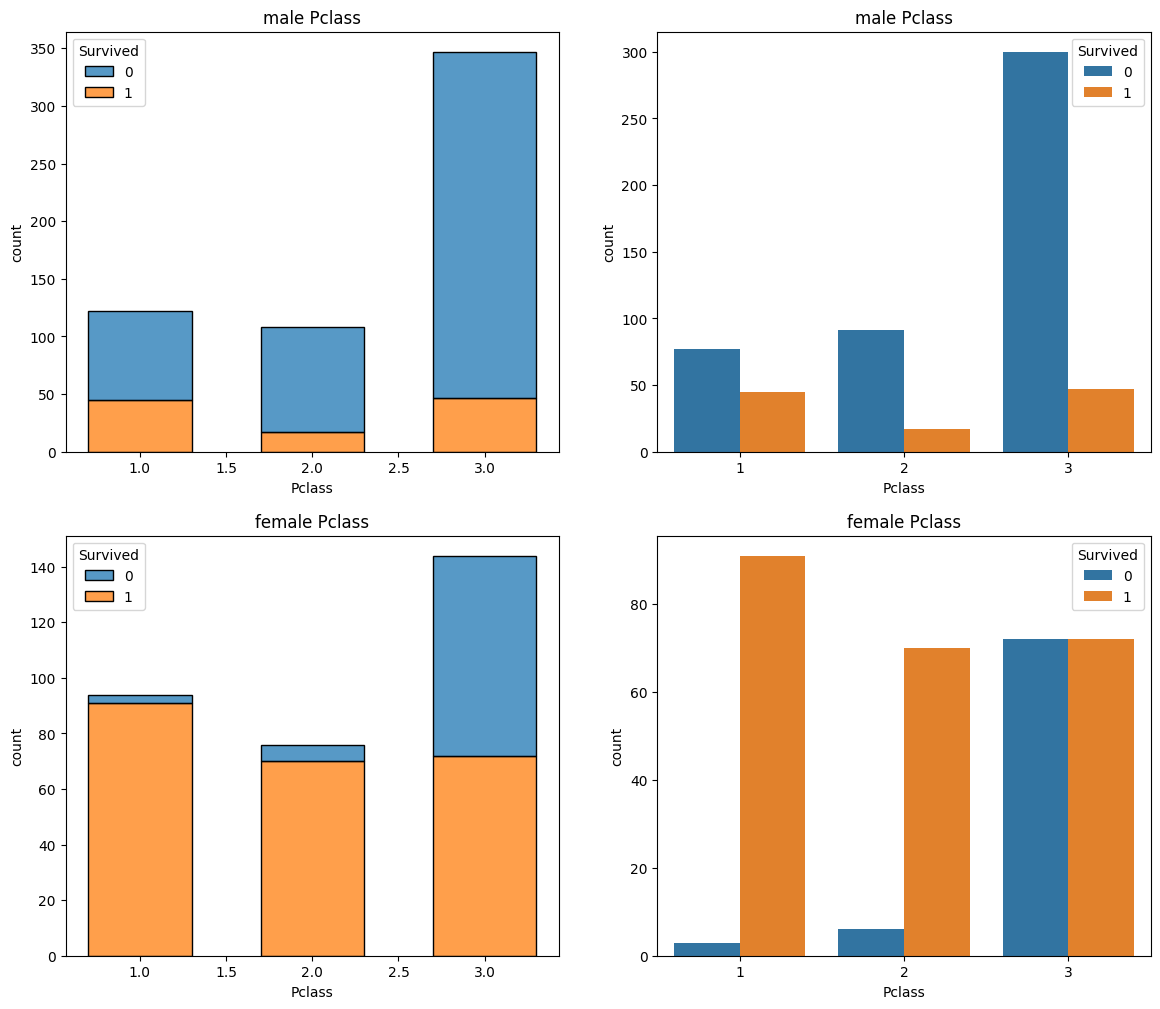

In [22]:
df_male = data.loc[
    (data["Sex"] == "male") &
    (data["Survived"].notna())
]

df_female = data.loc[
    (data["Sex"] == "female") &
    (data["Survived"].notna())
]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.histplot(
    data=df_male,
    x="Pclass",
    hue="Survived",
    multiple="stack",
    shrink=0.6,
    discrete=True,
    ax=axes[0, 0]
)


sns.countplot(
    data=df_male,
    x="Pclass",
    hue="Survived",
    dodge=True,      # 分开柱子
    ax=axes[0, 1]
)

sns.histplot(
    data=df_female,
    x="Pclass",
    hue="Survived",
    multiple="stack",
    shrink=0.6,
    discrete=True,
    ax=axes[1, 0]
)

sns.countplot(
    data=df_female,
    x="Pclass",
    hue="Survived",
    dodge=True,      # 分开柱子
    ax=axes[1, 1]
)

title_prefix = ['male', 'female']

for i in range(2):
    for j in range(2):
        axes[i, j].set_title(f"{title_prefix[i]} Pclass")
        axes[i, j].set_ylabel("count")



In [26]:
data['Ticket'].value_counts().shape

(929,)

In [27]:
def split_ticket(ticket: str):
    # 1. strip whitespace at both ends
    s = ticket.strip()

    # 2. split by the *last* whitespace
    if ' ' in s:
        prefix, number = s.rsplit(' ', 1)
    else:
        prefix, number = '', s

    # 3. uppercase the first part
    prefix = prefix.upper()

    # 4. remove '.' and whitespace in the first part
    prefix = prefix.replace('.', '').replace(' ', '')

    return prefix, number

In [28]:
data[['TicketPrefix', 'TicketNumber']] = (
    data['Ticket']
    .astype(str)
    .apply(lambda x: pd.Series(split_ticket(x)))
)

In [30]:
data['TicketPrefix'].value_counts()

TicketPrefix
              961
PC             92
CA             68
A/5            25
SOTON/OQ       24
STON/O2        21
SC/PARIS       19
W/C            15
A/4             9
FCC             9
C               8
SO/PP           7
SOC             7
PP              4
SC/AH           4
SOTON/O2        3
FC              3
A5              3
WE/P            2
SC/A4           2
SW/PP           2
SC              2
WEP             2
P/PP            2
FA              1
SCO/W           1
SOP             1
SP              1
SO/C            1
A4              1
A/S             1
SC/AHBASLE      1
CA/SOTON        1
SC/A3           1
STON/OQ         1
AQ/4            1
A2              1
LP              1
AQ/3            1
Name: count, dtype: int64

In [39]:
data['TicketNumberM1'] = data["TicketNumber"].str.replace(r".$", "X", regex=True)
data['TicketNumberM2'] = data["TicketNumber"].str.replace(r"..$", "XX", regex=True)

In [54]:

data["IsBoy"] = np.select(
    [
        data["Name"].str.contains("Master", na=False) |
        ((data["Sex"] == "male") & (data["Age"] < 13)),
        data["Sex"] == "male"
    ],
    [1, 2],
    default=3
)

In [52]:
data['Surname'] = data['Name'].str.extract('^([^,]+)', expand=False)

In [55]:
data.to_csv('tempcsv/wcgXticket.csv')

In [67]:
data[(data['PassengerId'] > 891) & (data["IsBoy"] != 2) & (data['Pclass'] == 3)].count()

PassengerId       89
Survived           0
Pclass            89
Name              89
Sex               89
Age               63
SibSp             89
Parch             89
Ticket            89
Fare              89
Cabin              1
Embarked          89
TicketPrefix      89
TicketNumber      89
TicketNumberM1    89
TicketNumberM2    89
isBoy             89
Surname           89
IsBoy             89
dtype: int64

In [68]:
data[data['TicketPrefix'].str.startswith('A/')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketPrefix,TicketNumber,TicketNumberM1,TicketNumberM2,isBoy,Surname,IsBoy
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,21171,2117X,211XX,False,Braund,2
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S,A/5,2151,215X,21XX,False,Saundercock,2
37,38,0,3,"Cann, Mr. Ernest Charles",male,21.0,0,0,A./5. 2152,8.0500,NaN,S,A/5,2152,215X,21XX,False,Cann,2
51,52,0,3,"Nosworthy, Mr. Richard Cater",male,21.0,0,0,A/4. 39886,7.8000,NaN,S,A/4,39886,3988X,398XX,False,Nosworthy,2
132,133,0,3,"Robins, Mrs. Alexander A (Grace Charity Laury)",female,47.0,1,0,A/5. 3337,14.5000,NaN,S,A/5,3337,333X,33XX,False,Robins,3
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,NaN,S,A/5,851,85X,8XX,False,van Billiard,2
204,205,1,3,"Cohen, Mr. Gurshon ""Gus""",male,18.0,0,0,A/5 3540,8.0500,NaN,S,A/5,3540,354X,35XX,False,Cohen,2
212,213,0,3,"Perkin, Mr. John Henry",male,22.0,0,0,A/5 21174,7.2500,NaN,S,A/5,21174,2117X,211XX,False,Perkin,2
227,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S,A/5,21173,2117X,211XX,False,Lovell,2
253,254,0,3,"Lobb, Mr. William Arthur",male,30.0,1,0,A/5. 3336,16.1000,NaN,S,A/5,3336,333X,33XX,False,Lobb,2


In [69]:
data['IsAgeMissing'] = data['Age'].isna().astype('int32')

In [82]:
data.iloc[:891].groupby(['IsBoy', 'Pclass', 'IsAgeMissing',])['Survived'].mean()

IsBoy  Pclass  IsAgeMissing
1      1       0                    1.0
       2       0                    1.0
       3       0                   0.36
               1                    0.5
2      1       0               0.377551
               1               0.238095
       2       0               0.066667
               1               0.222222
       3       0               0.127193
               1               0.077778
3      1       0               0.964706
               1                    1.0
       2       0               0.918919
               1                    1.0
       3       0               0.460784
               1               0.595238
Name: Survived, dtype: object

In [83]:
data.iloc[:891].groupby(['IsBoy', 'Pclass', 'IsAgeMissing', 'Survived'])['PassengerId'].count()

IsBoy  Pclass  IsAgeMissing  Survived
1      1       0             1             3
       2       0             1             9
       3       0             0            16
                             1             9
               1             0             2
                             1             2
2      1       0             0            61
                             1            37
               1             0            16
                             1             5
       2       0             0            84
                             1             6
               1             0             7
                             1             2
       3       0             0           199
                             1            29
               1             0            83
                             1             7
3      1       0             0             3
                             1            82
               1             1             9
       2       0 

In [87]:
data.iloc[:891].groupby(['IsBoy', 'Pclass', 'Survived'])['PassengerId'].count()

IsBoy  Pclass  Survived
1      1       1             3
       2       1             9
       3       0            18
               1            11
2      1       0            77
               1            42
       2       0            91
               1             8
       3       0           282
               1            36
3      1       0             3
               1            91
       2       0             6
               1            70
       3       0            72
               1            72
Name: PassengerId, dtype: int64

In [79]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketPrefix,TicketNumber,TicketNumberM1,TicketNumberM2,isBoy,Surname,IsBoy,IsAgeMissing
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,21171,2117X,211XX,False,Braund,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599,1759X,175XX,False,Cumings,3,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STON/O2,3101282,310128X,31012XX,False,Heikkinen,3,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,,113803,11380X,1138XX,False,Futrelle,3,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,,373450,37345X,3734XX,False,Allen,2,0


In [88]:
subset = data[
    (data["Pclass"] == 3) &
    (data["Sex"] == "female") &
    (data["SibSp"] == 0) &
    (data["Parch"] == 0)
]

subset["Surname"].value_counts().head(10)

Surname
McGowan      2
Connolly     2
Kelly        2
Nilsson      2
Carr         2
Cacic        2
Oreskovic    2
Glynn        1
Devaney      1
Heikkinen    1
Name: count, dtype: int64

In [89]:
subset = data[
    (data["Pclass"] == 3) &
    (data["IsBoy"] == 1) &
    (data["SibSp"] == 0) &
    (data["Parch"] == 0)
]

subset["Surname"].value_counts().head(10)

Surname
Hassan    1
Betros    1
Name: count, dtype: int64

In [ ]:
test['is_age_missing'] = test['Age'].isna()

In [ ]:
test[test['is_age_missing']]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_age_missing
10,902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,NaN,S,True
22,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,NaN,0,0,PC 17598,31.6833,NaN,S,True
29,921,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,NaN,C,True
33,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,True
36,928,3,"Roth, Miss. Sarah A",female,NaN,0,0,342712,8.0500,NaN,S,True
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1300,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q,True
410,1302,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q,True
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,True
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,True


In [ ]:
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [ ]:
print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [ ]:
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [ ]:
print(pd.crosstab(data['Title'], data['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     4
Countess       1     0
Don            0     1
Dona           1     0
Dr             1     7
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    61
Miss         260     0
Mlle           2     0
Mme            1     0
Mr             0   757
Mrs          197     0
Ms             2     0
Rev            0     8
Sir            0     1


In [ ]:
train[(train['Title'] == 'Master') & (train['Survived'] == 0)].size

(17, 13)

# Dig direction
* dig deeper into GoodWin Family
* if a boy died in a family
* if a girl died in a family




In [ ]:
data['Surname'] = data['Name'].apply(lambda x: x.split(',')[0])
train['Surname'] = train['Name'].str.extract('^([^,]+)', expand=False)

In [ ]:
train[(train['Surname'] == 'Goodwin')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9,NaN,S,Master,Goodwin
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9,NaN,S,Miss,Goodwin
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9,NaN,S,Master,Goodwin
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9,NaN,S,Master,Goodwin
678,679,0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.9,NaN,S,Mrs,Goodwin
683,684,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9,NaN,S,Mr,Goodwin


In [90]:
# 1. 只保留纯数字 ticket
ticket_num = data["Ticket"].astype(str)

# 2. 选出长度正好为 4 的
mask_4digit = ticket_num.str.fullmatch(r"\d{4}")

# 3. 分组计数
ticket4_counts = (
    data.loc[mask_4digit]
        .assign(Ticket4=ticket_num[mask_4digit])
        .groupby("Ticket4")
        .size()
        .sort_values(ascending=False)
)

ticket4_counts

Ticket4
1601    8
4133    5
2666    4
2662    3
2653    3
       ..
7935    1
8471    1
8475    1
9232    1
9234    1
Length: 104, dtype: int64

In [91]:
ticket4_counts.value_counts()

1    81
2    14
3     6
8     1
5     1
4     1
Name: count, dtype: int64

In [92]:


mask_5digit = ticket_num.str.fullmatch(r"\d{5}")

# 3. 分组计数
ticket5_counts = (
    data.loc[mask_5digit]
        .assign(Ticket5=ticket_num[mask_5digit])
        .groupby("Ticket5")
        .size()
        .sort_values(ascending=False)
)

ticket5_counts.value_counts()

1    69
2    32
3    11
4     4
5     1
6     1
Name: count, dtype: int64

In [93]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'TicketPrefix',
       'TicketNumber', 'TicketNumberM1', 'TicketNumberM2', 'isBoy', 'Surname',
       'IsBoy', 'IsAgeMissing'],
      dtype='object')

In [94]:
data['TicketNumberLength'] = data['TicketNumber'].str.len()

In [95]:
data['TicketNumberLength'].value_counts()

TicketNumberLength
6    606
5    377
4    249
7     60
3     13
1      4
Name: count, dtype: int64

In [102]:
data.loc[data['TicketNumberLength'] == 4].groupby('TicketNumber')['PassengerId'].count().sort_values(ascending=False).to_csv('tempcsv/wcgXticket4_count.csv')

In [106]:
data.loc[data['TicketNumberLength'] == 4].groupby('TicketNumberM1')['PassengerId'].count().sort_values(ascending=False).to_csv('tempcsv/wcgXticket4M1_count.csv')

In [108]:
data.loc[data['TicketNumberLength'] == 4].groupby(['TicketPrefix', 'TicketNumber'])['PassengerId'].count().sort_values(ascending=False).head(20)

TicketPrefix  TicketNumber
CA            2343            11
              1601             8
CA            2144             8
              4133             5
W/C           6608             5
              6607             4
              2666             4
              LINE             4
SC/PARIS      2123             4
CA            2315             4
              2650             3
              2661             3
              2662             3
              2668             3
C             4001             3
              2653             3
CA            2673             3
PP            9549             3
SC/PARIS      2079             3
              2678             3
Name: PassengerId, dtype: int64

In [ ]:
data.loc[data['TicketNumberLength'] == 4].groupby(['TicketPrefix', 'TicketNumberM1'])['PassengerId'].count().sort_values(ascending=False).to_csv('tempcsv/wcgXticket4PrefixNumberM1_count_2.csv') 
data.loc[data['TicketNumberLength'] == 4].groupby(['TicketPrefix', 'TicketNumber'])['PassengerId'].count().sort_values(ascending=False).to_csv('tempcsv/wcgXticket4PrefixNumber_count_2.csv')

In [114]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'TicketPrefix',
       'TicketNumber', 'TicketNumberM1', 'TicketNumberM2', 'isBoy', 'Surname',
       'IsBoy', 'IsAgeMissing', 'TicketNumberLength'],
      dtype='object')

In [121]:
df_m1 = data[data["TicketNumberM1"].notna()].copy()
surname_cnt = (
    df_m1
    .groupby(["TicketPrefix", "TicketNumberM1", "Surname"])
    .size()
    .reset_index(name="surname_n")
)

same_surname_groups = surname_cnt.query("surname_n >= 2")

In [122]:
result = df_m1.merge(
    same_surname_groups[["TicketPrefix", "TicketNumberM1", "Surname"]],
    on=["TicketPrefix", "TicketNumberM1", "Surname"],
    how="inner"
)

In [128]:
# 你已有的结果表：result
# 需要的列：TicketPrefix, TicketNumberM1(或你叫 TicketM1), Ticket

m1_col = "TicketNumberM1"   # 改成你实际列名，比如 "TicketM1"
prefix_col = "TicketPrefix"   # 改成你实际列名，比如 "TicketPrefix"

mask = (
    result.groupby([prefix_col, m1_col])["Ticket"]
          .transform("nunique")
          .gt(1)   # >1 表示这个 M1 桶里有多个不同原始 Ticket
)

out = result.loc[mask].sort_values([prefix_col, m1_col, "Ticket", "Surname", "PassengerId"])

out_one_per_ticket = (
    out.drop_duplicates(subset=[prefix_col, m1_col, "Ticket"])
       .sort_values([prefix_col, m1_col, "Ticket"])
)
out_one_per_ticket.to_csv("tempcsv/wcgXticketM1_multiDif_original_tickets.csv", index=False)


In [129]:
data.to_csv('tempcsv/wcgXticket_fulldata.csv', index=False)